<b>Target :</b>

```1. Add Batch Normalization to increase model efficiency  ```

In [ ]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 173293504.97it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107389799.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50608403.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9292940.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

cuda


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [ ]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels))

    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = self.conv_block(1, 10, 3)
      self.conv2 = self.conv_block(10, 10, 3, 0)
      self.conv3 = self.conv_block(10, 11, 3)
      self.conv4 = self.conv_block(11, 11, 3, 0)
      self.conv5 = self.conv_block(11, 12, 3)
      self.conv6 = self.conv_block(12, 12, 3, 0)
      self.conv7 = self.out_block(12, 3)
      self.pool = nn.MaxPool2d(2, 2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
            Conv2d-4           [-1, 10, 26, 26]             900
              ReLU-5           [-1, 10, 26, 26]               0
       BatchNorm2d-6           [-1, 10, 26, 26]              20
         MaxPool2d-7           [-1, 10, 13, 13]               0
            Conv2d-8           [-1, 11, 13, 13]             990
              ReLU-9           [-1, 11, 13, 13]               0
      BatchNorm2d-10           [-1, 11, 13, 13]              22
           Conv2d-11           [-1, 11, 11, 11]           1,089
             ReLU-12           [-1, 11, 11, 11]               0
      BatchNorm2d-13           [-1, 11, 11, 11]              22
        MaxPool2d-14             [-1, 1

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.11831416934728622 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]



Test set: Average loss: 0.0562, Accuracy: 9821/10000 (98.21%)

EPOCH: 1


Loss=0.028664911165833473 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0441, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.015203041024506092 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]



Test set: Average loss: 0.0354, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.09142541885375977 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]



Test set: Average loss: 0.0356, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.022652536630630493 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]



Test set: Average loss: 0.0323, Accuracy: 9893/10000 (98.93%)

EPOCH: 5


Loss=0.007667491678148508 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]



Test set: Average loss: 0.0323, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.0023891024757176638 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss: 0.0346, Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.04150700196623802 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:18<00:00, 25.65it/s]



Test set: Average loss: 0.0335, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.02147308550775051 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]



Test set: Average loss: 0.0309, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.04497388377785683 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:16<00:00, 28.89it/s]



Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.008166841231286526 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]



Test set: Average loss: 0.0307, Accuracy: 9905/10000 (99.05%)

EPOCH: 11


Loss=0.002687260275706649 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]



Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.012066193856298923 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]



Test set: Average loss: 0.0315, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.0034631111193448305 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]



Test set: Average loss: 0.0279, Accuracy: 9913/10000 (99.13%)

EPOCH: 14


Loss=0.011372952722012997 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]



Test set: Average loss: 0.0316, Accuracy: 9900/10000 (99.00%)



Text(0.5, 1.0, 'Test Accuracy')

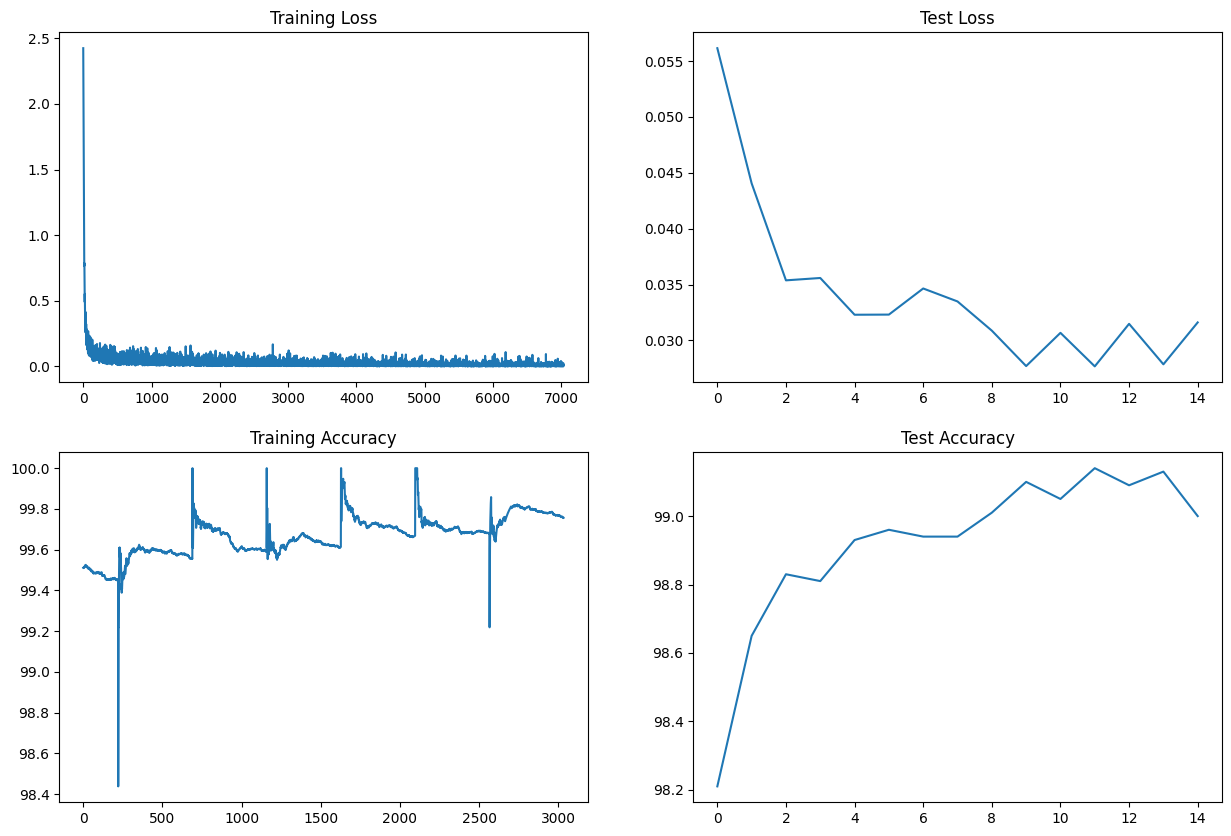

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Results:

<b>Parameters:</b> 6,765

<b>Best Train Accuracy:</b> 99.76

<b>Best Test Accuracy:</b> 99.14

<b>Analysis:</b>
Batch normalization reduces internal covariate shift by controlling the mean and variance of input distributions helping in faster convergence. From the above network result we can abserve that its overfitting and with the help of dropout and image augmentation we can reduce this overfitting and acheive the required target